In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = Georgia
state_ab = "ga"

## Data
1. Download all the data in directory "ga_data"
2. Extract them all

In [4]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2021/CONGRESS-PROP1-2021-shape.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2021/SENATE-PROP1-2021-Shape.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2021/HOUSE-PROP1-2021-shape.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [5]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [6]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [7]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [8]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [9]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [10]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [11]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [12]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [13]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [14]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [15]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [16]:
maup.doctor(population_df)

100%|███████████████████████████████████████| 232717/232717 [01:47<00:00, 2158.03it/s]


True

In [17]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [18]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [19]:
population_df.rename(columns=rename_dict, inplace = True)

Make sure that the County shapefile is clean:

In [20]:
maup.doctor(county_df)

100%|██████████████████████████████████████████████| 159/159 [00:00<00:00, 258.39it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [21]:
vest20 = gpd.read_file(vest20_data)

In [22]:
vest20.columns

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'R21USSRPER', 'R21USSDOSS',
       'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA', 'geometry'],
      dtype='object')

### vest 20 is not working, so we use vest 16 as our base data

In [23]:
vest16 = gpd.read_file(vest16_data)

In [24]:
vest16.columns

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16USSRISA', 'G16USSDBAR', 'G16USSLBUC', 'G16PSCRECH',
       'G16PSCLHOS', 'geometry'],
      dtype='object')

In [25]:
start_col = 8
vest_base_data = vest16
year = '16'

In [26]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|██████████████████████████████████████████████| 159/159 [00:00<00:00, 256.47it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|███████████████████████████████████████████████| 159/159 [00:02<00:00, 74.93it/s]


Identifying overlaps...


100%|█████████████████████████████████████████| 11436/11436 [00:07<00:00, 1618.81it/s]


Resolving overlaps and filling gaps...


Gaps to simplify in region 0: 100%|███████████████████| 73/73 [00:02<00:00, 33.75it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 2: 100%|███████████████████| 50/50 [00:01<00:00, 37.98it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 3: 100%|██████████████████| 25/25 [00:00<00:00, 123.89it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 5: 100%|██████████████████| 12/12 [00:00<00:00, 107.08it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 6: 100%|███████████████████| 67/67 [00:00<00:00, 78.60it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 8: 100%|██████████████████| 18/18 [00:00<00:00, 121.04it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 11: 100%|██████████████████| 69/69 [00:00<00:00, 79.77it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 12: 100%|█████████████████| 42/42 [00:00<00:00, 122.08it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 13: 100%|████

In [27]:
borders = check_small_boundary_lengths(vest_base)
print(borders[:1700])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [28]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████████| 3116/3116 [00:01<00:00, 2255.15it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|████████████████████████████████████████████| 2697/2697 [00:03<00:00, 742.58it/s]


In [29]:
maup.doctor(vest_base)

100%|████████████████████████████████████████████| 2697/2697 [00:03<00:00, 772.78it/s]


True

## If it is true for maup doctor, we will use it as the base vest data.

In [30]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|████████████████████████████████████████████| 2697/2697 [00:18<00:00, 143.09it/s]


In [31]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [32]:
election_df = gpd.GeoDataFrame(vest_base)

In [33]:
election_df.columns

Index(['CTYNAME', 'CTYNUMBER', 'CTYNUMBER2', 'CTYSOSID', 'DISTRICT', 'FIPS2',
       'PRE16D', 'PRE16O', 'PRE16R', 'PRECINCT_I', 'PRECINCT_N', 'PSC16O',
       'PSC16R', 'USS16D', 'USS16O', 'USS16R', 'geometry', 'TOTPOP', 'HISP',
       'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER',
       'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI',
       'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP',
       'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [34]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [35]:
vest18 = gpd.read_file(vest18_data)

In [36]:
vest18.columns

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G18GOVRKEM', 'G18GOVDABR',
       'G18GOVLMET', 'G18LTGRDUN', 'G18LTGDAMI', 'G18SOSRRAF', 'G18SOSDBAR',
       'G18SOSLDUV', 'G18ATGRCAR', 'G18ATGDBAI', 'G18AGRRBLA', 'G18AGRDSWA',
       'G18INSRBEC', 'G18INSDLAW', 'G18INSLFOS', 'G18SPIRWOO', 'G18SPIDTHO',
       'G18LABRBUT', 'G18LABDKEA', 'G18PSCREAT', 'G18PSCDMIL', 'G18PSCLGRA',
       'G18PSCRPRI', 'G18PSCDRAN', 'G18PSCLTUR', 'R18SOSRRAF', 'R18SOSDBAR',
       'R18PSCREAT', 'R18PSCDMIL', 'geometry'],
      dtype='object')

In [37]:
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|████████████████████████████████████████████| 2658/2658 [00:04<00:00, 614.52it/s]


There are 347 overlaps.
There are 564 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████████| 4653/4653 [00:01<00:00, 2567.35it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|████████████████████████████████████████████| 2697/2697 [00:17<00:00, 151.69it/s]


population agrees


In [38]:
election_df = add_vest(vest20, election_df, '20', population_df, start_col)

GEOSException: TopologyException: side location conflict at 196134.12780460934 3741714.122431715. This can occur if the input geometry is invalid.

##  Add the district data

In [39]:
cd = gpd.read_file(cd_data)
cd = cd.to_crs(cd.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [40]:
cd.head()

,ID,AREA,DATA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,F18_POP,NH_WHT,...,F_AP_HWN,F_AP_OTH,F_18_AP_WH,F_18_AP_IN,F_18_AP_AS,F_18_AP_HW,F_18_AP_OT,F_PEOPLE_I,IDEAL_VALU,geometry
0,1,599.114258,5,013,1.0,None,None,765137,574789,125106,...,0.001472,0.104958,0.000416,0.000029,0.000043,0.000001,0.000143,0.006238,765136.0,"POLYGON ((176433.370 3746423.235, 176413.770 3..."
1,2,1168.543210,3,011,1.0,None,None,765137,595201,469264,...,0.001412,0.115147,0.000668,0.000038,0.000068,0.000003,0.000138,0.015703,765136.0,"POLYGON ((180172.280 3748325.841, 180166.990 3..."
2,3,250.457443,10,005,1.0,None,None,765137,621515,273819,...,0.001432,0.064441,0.000271,0.000013,0.000033,0.000001,0.000036,0.050784,765136.0,"POLYGON ((175612.647 3745359.219, 175703.728 3..."
3,257,417.795990,9,004,1.0,None,None,765135,589470,197536,...,0.001445,0.104404,0.000381,0.000018,0.000037,0.000001,0.000060,0.008533,765136.0,"POLYGON ((236402.018 3716651.736, 236399.074 3..."
4,258,322.790497,12,007,1.0,None,None,765137,566934,225905,...,0.001771,0.205277,0.000138,0.000008,0.000042,0.000000,0.000045,0.002537,765136.0,"POLYGON ((237073.706 3754128.735, 236874.015 3..."


In [41]:
election_df = add_district(cd, "CD", election_df, "DISTRICT")

100%|█████████████████████████████████████████████████| 14/14 [00:01<00:00, 12.60it/s]


In [42]:
send.head()

,ID,AREA,DATA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,F18_POP,NH_WHT,...,F_AP_HWN,F_AP_OTH,F_18_AP_WH,F_18_AP_IN,F_18_AP_AS,F_18_AP_HW,F_18_AP_OT,F_PEOPLE_I,IDEAL_VALU,geometry
0,1,873.386475,128,030,1.0,None,None,191475,145077,128237,...,0.001128,0.063079,0.000581,0.000047,0.000012,0.000001,0.000041,0.018274,191284.0,"POLYGON ((134878.537 3752731.801, 134916.954 3..."
1,2,577.962463,97,031,1.0,None,None,192560,142251,125543,...,0.001662,0.074320,0.000442,0.000027,0.000021,0.000002,0.000058,0.005526,191284.0,"POLYGON ((148686.115 3777848.012, 148710.861 3..."
2,3,912.498718,96,052,1.0,None,None,190799,146620,136991,...,0.001069,0.085116,0.000432,0.000016,0.000007,0.000000,0.000026,0.022773,191284.0,"POLYGON ((163587.858 3797474.104, 163585.561 3..."
3,4,1222.852050,92,053,1.0,None,None,190236,148201,163183,...,0.001582,0.036607,0.000892,0.000070,0.000061,0.000001,0.000277,0.025169,191284.0,"POLYGON ((136675.831 3878915.523, 136672.059 3..."
4,5,150.381927,111,037,1.0,None,None,192671,147779,120179,...,0.001464,0.090164,0.000374,0.000022,0.000034,0.000001,0.000060,0.004438,191284.0,"POLYGON ((168195.079 3760379.119, 168190.325 3..."


In [43]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|█████████████████████████████████████████████████| 56/56 [00:01<00:00, 29.86it/s]


In [44]:
hdist.head()

,ID,AREA,DATA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,F18_POP,NH_WHT,...,F_AP_HWN,F_AP_OTH,F_18_AP_WH,F_18_AP_IN,F_18_AP_AS,F_18_AP_HW,F_18_AP_OT,F_PEOPLE_I,IDEAL_VALU,geometry
0,1,2621.328120,195,154,1.0,None,None,59994,47273,23723,...,0.001300,0.017752,0.000171,0.000012,0.000002,0.000001,0.000031,0.041071,59511.0,"POLYGON ((153749.202 3444062.240, 153746.719 3..."
1,2,642.327576,306,173,1.0,None,None,59743,45292,31465,...,0.000603,0.060375,0.000316,0.000010,0.000005,0.000000,0.000020,0.010160,59511.0,"POLYGON ((204545.741 3397732.632, 204520.085 3..."
2,3,1414.718260,304,171,1.0,None,None,59237,45969,30345,...,0.001080,0.049597,0.000147,0.000004,0.000001,0.000000,0.000007,0.042946,59511.0,"POLYGON ((176127.400 3400126.525, 176123.189 3..."
3,4,27.224514,176,140,1.0,None,None,59294,44411,17055,...,0.004857,0.071542,0.002879,0.000243,0.000226,0.000074,0.000872,0.045839,59511.0,"POLYGON ((126244.482 3589246.154, 126239.970 3..."
4,5,547.062561,541,138,1.0,None,None,58912,45684,41408,...,0.002139,0.035205,0.000285,0.000007,0.000010,0.000001,0.000010,0.021914,59511.0,"POLYGON ((124205.608 3603719.389, 124197.225 3..."


In [45]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|███████████████████████████████████████████████| 180/180 [00:03<00:00, 58.85it/s]


In [46]:
maup.doctor(election_df)

100%|████████████████████████████████████████████| 2697/2697 [00:03<00:00, 804.15it/s]


True

### Put the base precinct year after the precinct information column

In [47]:
base_columns = {}
if 'CTYSOSID' + year not in election_df.columns:
    base_columns = {
        'DISTRICT':'DISTRICT'+year,
        'CTYSOSID':'CTYSOSID'+year,
        'PRECINCT_I':'PRECINCT_I'+year,
        'PRECINCT_N':'PRECINCT_N'+year,
        'CTYNAME':'CTYNAME'+year,
        'CTYNUMBER':'CTYNUMBER'+year,
        'CTYNUMBER2':'CTYNUMBER2'+year,
        'FIPS2':'FIPS2'+year,
    }
election_df.rename(columns=base_columns, inplace = True)

In [48]:
# reorder the columns
fixed_columns = [
    'DISTRICT'+year,
    'CTYSOSID'+year,
    'PRECINCT_I'+year,
    'PRECINCT_N'+year,
    'CTYNAME'+year,
    'CTYNUMBER'+year,
    'CTYNUMBER2'+year,
    'FIPS2'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [49]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

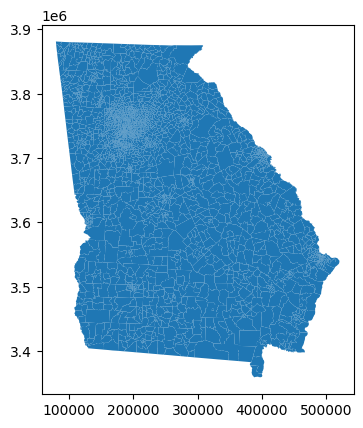

In [50]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()